In [4]:
import torch
import torch.optim as optim
import numpy as np
import time
from datasets import Robot_Traj_Dataset_Experiment_Sim
from torch.utils.data import DataLoader,Dataset

import matplotlib.pyplot as plt

from losses import log_prob_loss, task_loss_rgb, task_loss, task_loss_with_deform
from networks import NFSMP_Image, NFSMP_Image_Inference
from visualize import img_predict, img_predict_inference, img_predict_interp
from evaluate import traj_field, validate, test
import pickle
import cv2
import copy
from tqdm import tqdm

%matplotlib inline

train = False

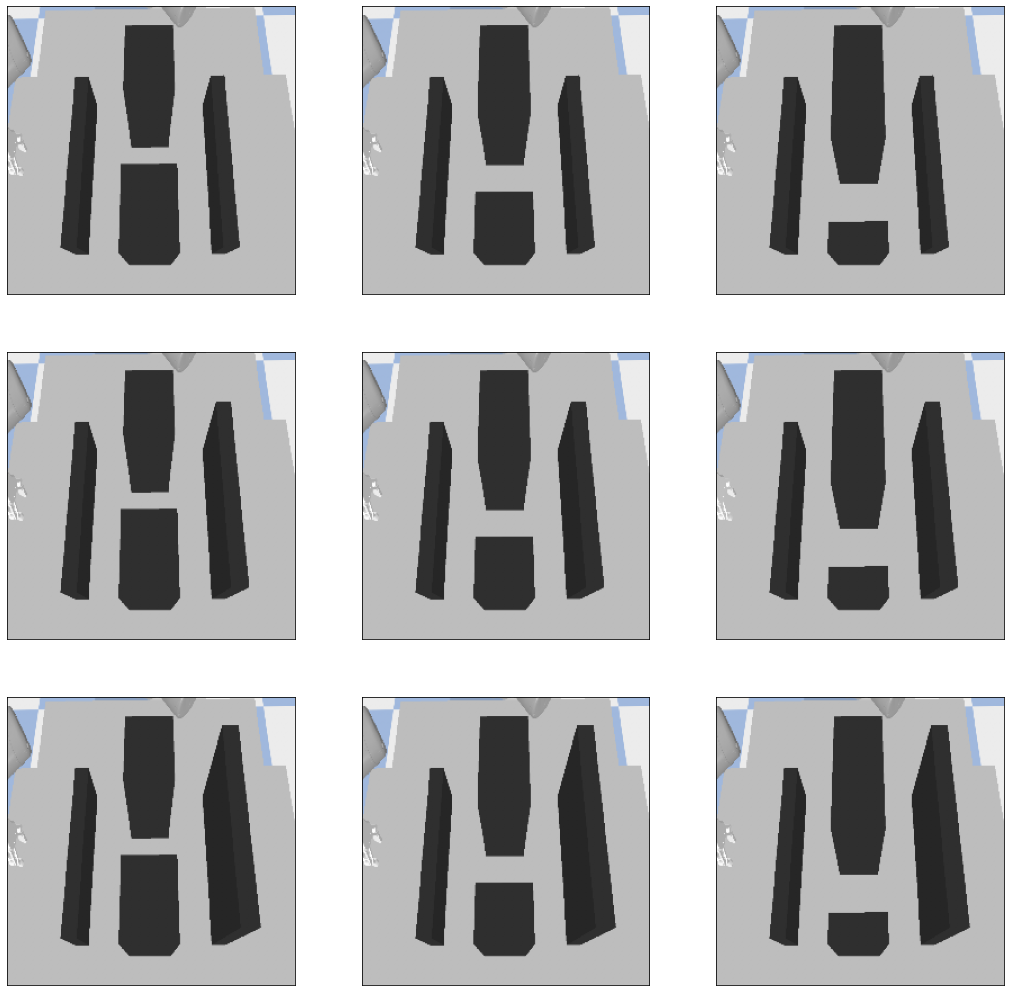

In [5]:
traj_count = 27
task = "ur10_between_walls_exp_3x3x3"
task_id = 2
dataset = Robot_Traj_Dataset_Experiment_Sim(task,traj_count, task_id)
dataloader = DataLoader(dataset, shuffle=True,batch_size=9, num_workers=0, drop_last = True)
fig,ax=plt.subplots(3,3,figsize=(18,18))
for i in range(9):
    ax[i//3,i%3].imshow(dataset.demo_img[i]/255.0)
    ax[i//3,i%3].get_xaxis().set_visible(False)
    ax[i//3,i%3].get_yaxis().set_visible(False)
plt.show()

In [6]:
if train:
    total_steps=0
    epochs = 1500
    lowest_mp_loss = 1000
    for seed in range(10):
        model = NFSMP_Image(traj_count,L=8,L2=2)
        model.to(device=torch.device('cuda:0'))
        optim = torch.optim.Adam([
                        {'params': model.mp_net.parameters()},
                        {'params': model.rgb_net.parameters()},
                        {'params': model.deform_net.parameters()},
                        {'params': model.hyper_net_mp.parameters()},
                        {'params': model.hyper_net_deform.parameters()},
                        {'params': model.latent_codes.parameters(),'lr':1e-4},
                    ],
            lr=1e-3)
        lowest_mp_loss_epoch = 1000
        with tqdm(total = len(dataloader) * epochs) as pbar:
            train_losses = []
            for epoch in range(epochs):
                if epoch%200==199:
                    img_predict_interp(model,128,epoch,0,26)
                model.train()
                epoch_mp_losses = []        
                for step, (model_input, gt) in enumerate(dataloader):

                    start_time = time.time()
                    model_input = {key: value.cuda() for key, value in model_input.items()}
                    gt = {key: value.cuda() for key, value in gt.items()}

                    losses = model(model_input,gt,epoch)

                    train_loss = 0.
                    for loss_name, loss in losses.items():
                        single_loss = loss.mean()
                        if epoch %100== 0 and step==0:
                            print(loss_name,single_loss)
                        train_loss += single_loss            

                    epoch_mp_losses.append(train_loss.item())            
                    train_losses.append(losses['mp'].item())
                    optim.zero_grad()
                    train_loss.backward()
                    optim.step()
                    pbar.update(1)
                    pbar.set_postfix(loss=train_loss.item(), time=time.time() - start_time, epoch=epoch)
                    total_steps += 1
                if epoch>1000 and epoch%20==0:
                    curr_error = validate(model, experiment_name=task,num_of_traj=traj_count,task_id=task_id)
                    if curr_error<lowest_mp_loss:
                        print(curr_error,epoch)
                        lowest_mp_loss=curr_error
                        checkpoint = copy.deepcopy(model.state_dict())
else:
    model = NFSMP_Image(traj_count,L=8,L2=2)
    model.to(device=torch.device('cuda:0'))
    model.load_state_dict(torch.load("sim_exp_2"))
    model.eval()

SingleBVPNet(
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(
          in_features=17, out_features=256, bias=True
          (softplus): Softplus(beta=1, threshold=20)
        )
        (1): ReLU(inplace=True)
      )
      (1): MetaSequential(
        (0): BatchLinear(
          in_features=256, out_features=256, bias=True
          (softplus): Softplus(beta=1, threshold=20)
        )
        (1): ReLU(inplace=True)
      )
      (2): MetaSequential(
        (0): BatchLinear(
          in_features=256, out_features=256, bias=True
          (softplus): Softplus(beta=1, threshold=20)
        )
        (1): ReLU(inplace=True)
      )
      (3): MetaSequential(
        (0): BatchLinear(
          in_features=256, out_features=256, bias=True
          (softplus): Softplus(beta=1, threshold=20)
        )
        (1): ReLU(inplace=True)
      )
      (4): MetaSequential(
        (0): BatchLinear(
          in_features=256, out_features=6, bi

In [10]:
if train:
    model.load_state_dict(checkpoint)
    torch.save(model.state_dict(), "sim_exp_2")
    print(lowest_mp_loss)
    model.eval()

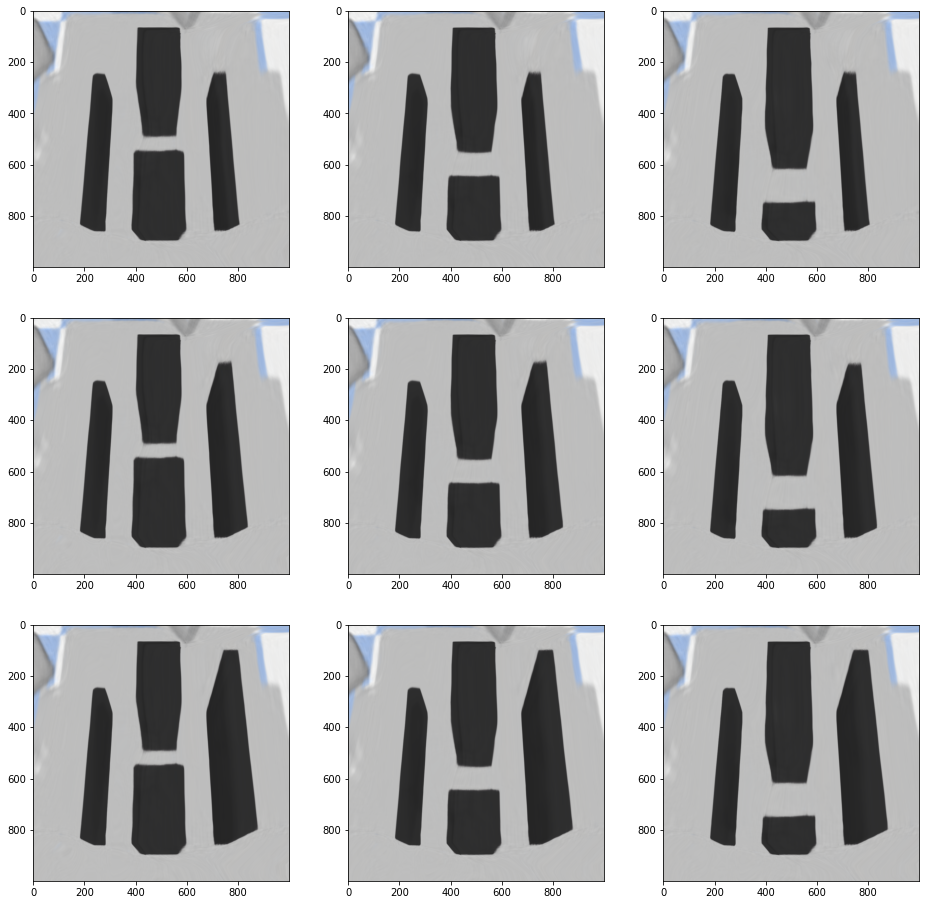

In [11]:
%matplotlib inline
img_predict(model,1000)

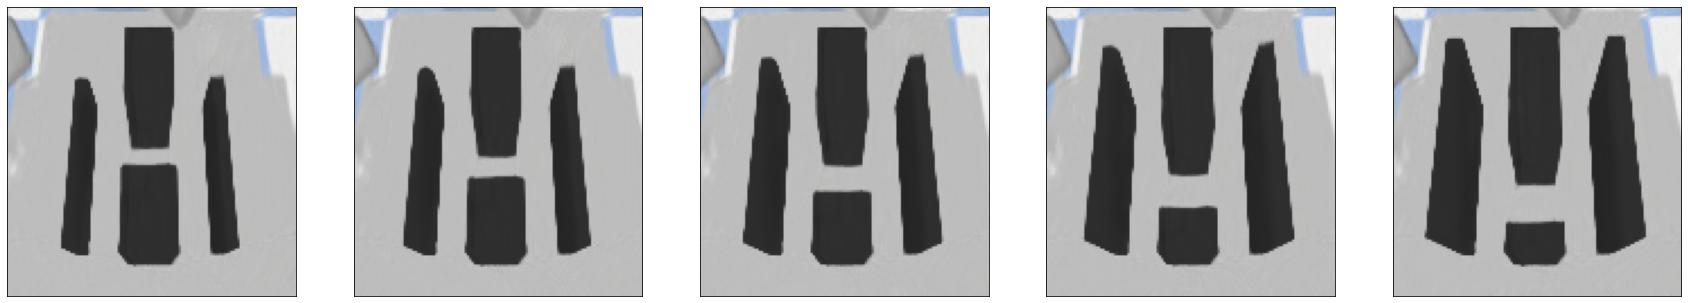

In [12]:
img_predict_interp(model,128,1000,0,26)

In [13]:
%matplotlib inline
tests={
    "3x3x3":("ur10_between_walls_exp_3x3x3",27),
    "4x4x4":("ur10_between_walls_exp_4x4x4",64),
    "5x5x5":("ur10_between_walls_exp_5x5x5",125),
}
test_datasets = dict()
test_dataloaders = dict()
test_models = dict()
for label in tests:
    test_datasets[label] = Robot_Traj_Dataset_Experiment_Sim(tests[label][0],tests[label][1],task_id)
    test_dataloaders[label] = DataLoader(test_datasets[label], shuffle=False,batch_size=40, num_workers=0, drop_last = False)  
    test_models[label] = NFSMP_Image_Inference(tests[label][1],model)

  0%|         | 1/200 [00:00<00:46,  4.28it/s, epoch=0, loss=2226.5, time=0.215]

rgb tensor(2226.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▍    | 99/200 [00:19<00:20,  4.97it/s, epoch=98, loss=21.5, time=0.182]

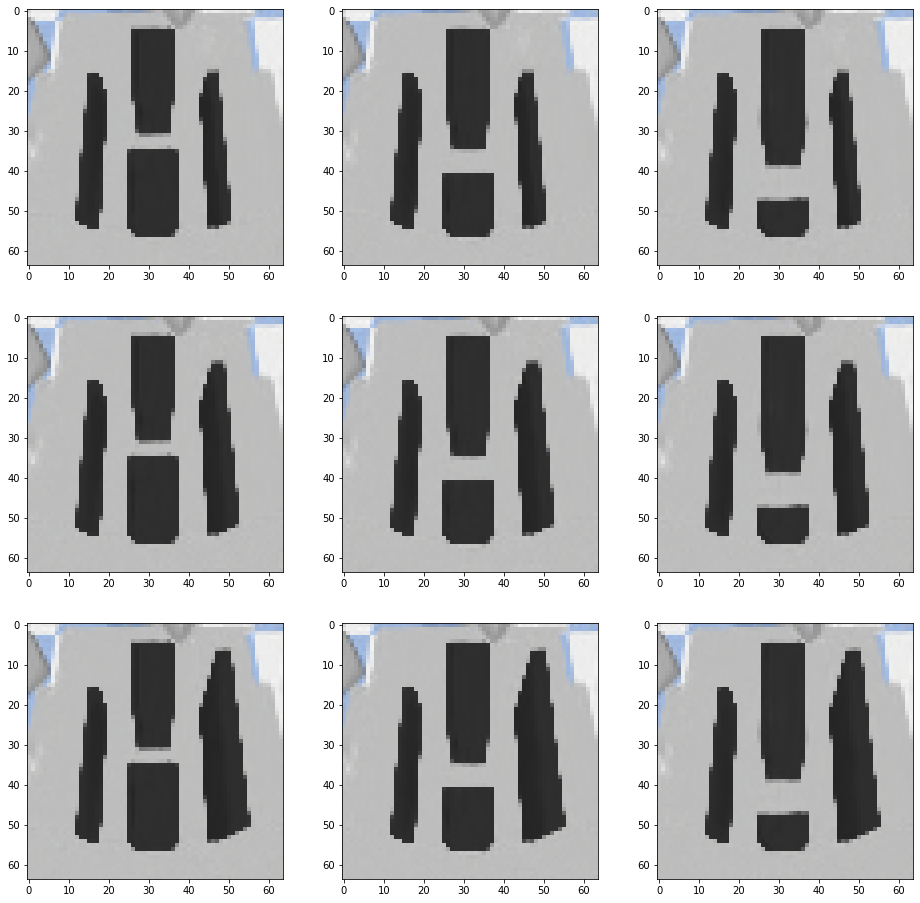

 50%|███▌   | 101/200 [00:20<00:33,  2.96it/s, epoch=100, loss=21.5, time=0.184]

rgb tensor(21.5444, device='cuda:0', grad_fn=<MeanBackward0>)


100%|████████▉| 199/200 [00:40<00:00,  4.93it/s, epoch=198, loss=21, time=0.183]

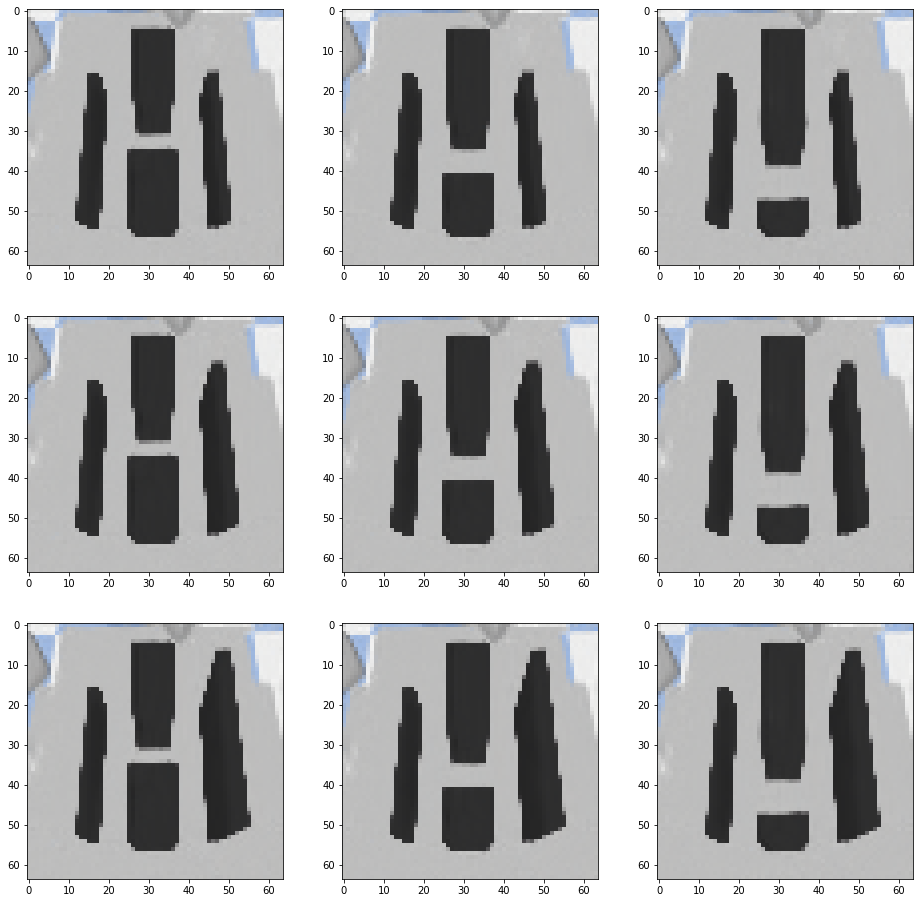

  0%|                                           | 1/400 [00:00<01:01,  6.46it/s]

rgb tensor(2210.0620, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|███▉    | 198/400 [00:46<00:49,  4.11it/s, epoch=98, loss=31.1, time=0.163]

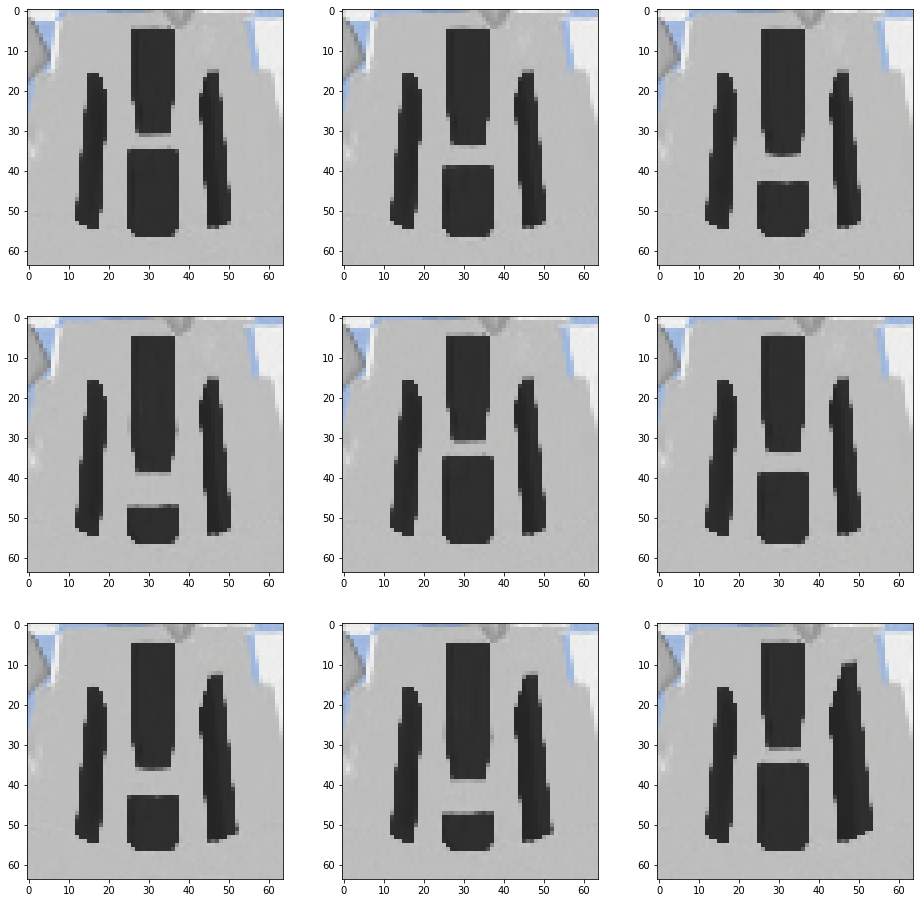

 50%|████    | 201/400 [00:48<01:08,  2.91it/s, epoch=99, loss=30.7, time=0.162]

rgb tensor(37.4121, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████▉| 398/400 [01:34<00:00,  4.14it/s, epoch=198, loss=29.7, time=0.162]

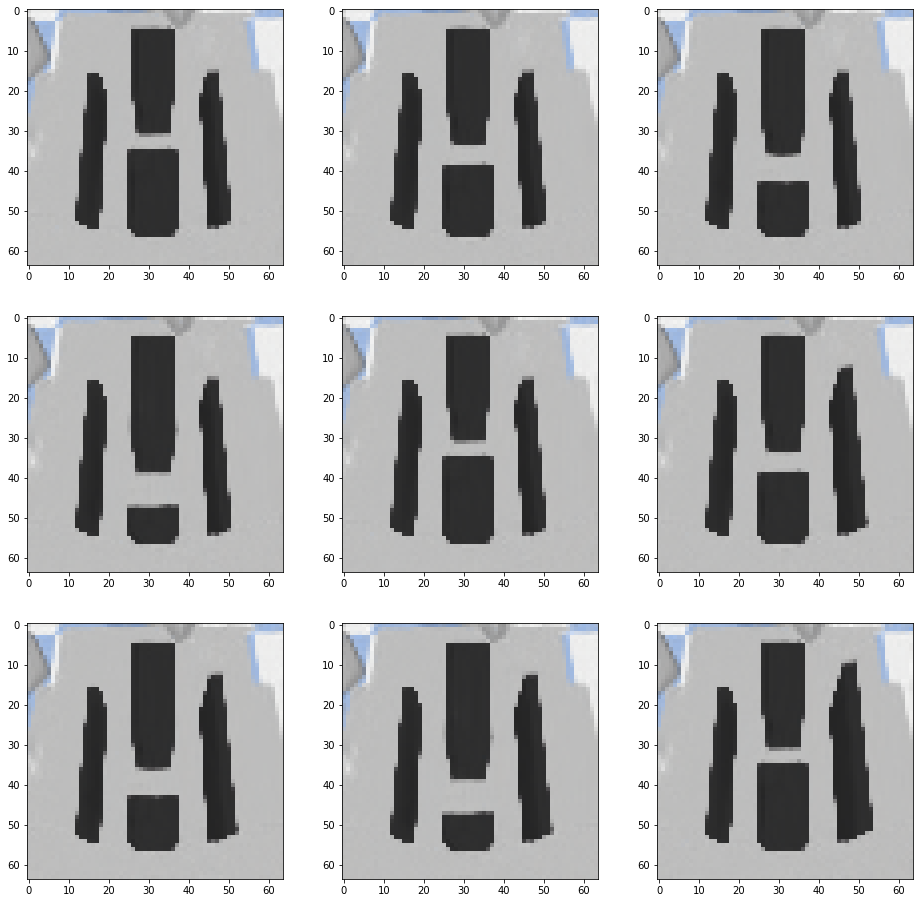

  0%|                                           | 1/800 [00:00<01:31,  8.72it/s]

rgb tensor(2193.2891, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|███▍   | 396/800 [01:31<01:38,  4.09it/s, epoch=98, loss=25.1, time=0.0437]

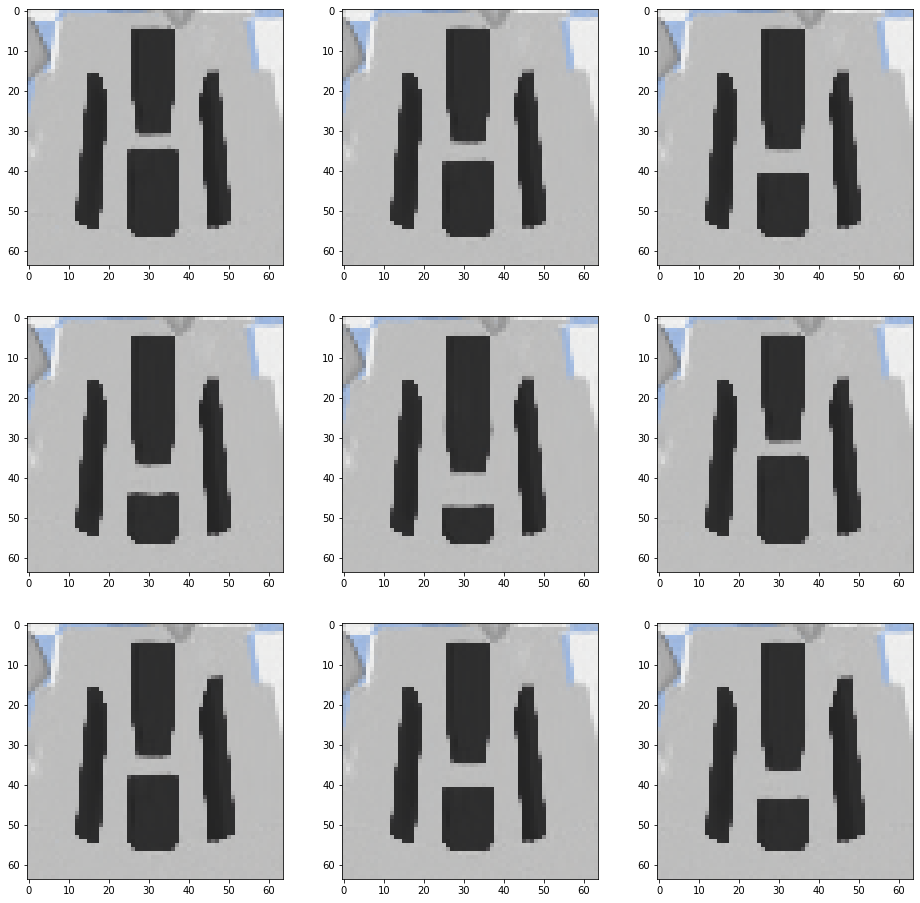

 50%|████    | 401/800 [01:33<01:42,  3.88it/s, epoch=99, loss=25.1, time=0.043]

rgb tensor(29.6906, device='cuda:0', grad_fn=<MeanBackward0>)


100%|█████▉| 796/800 [03:05<00:00,  4.11it/s, epoch=198, loss=25.7, time=0.0429]

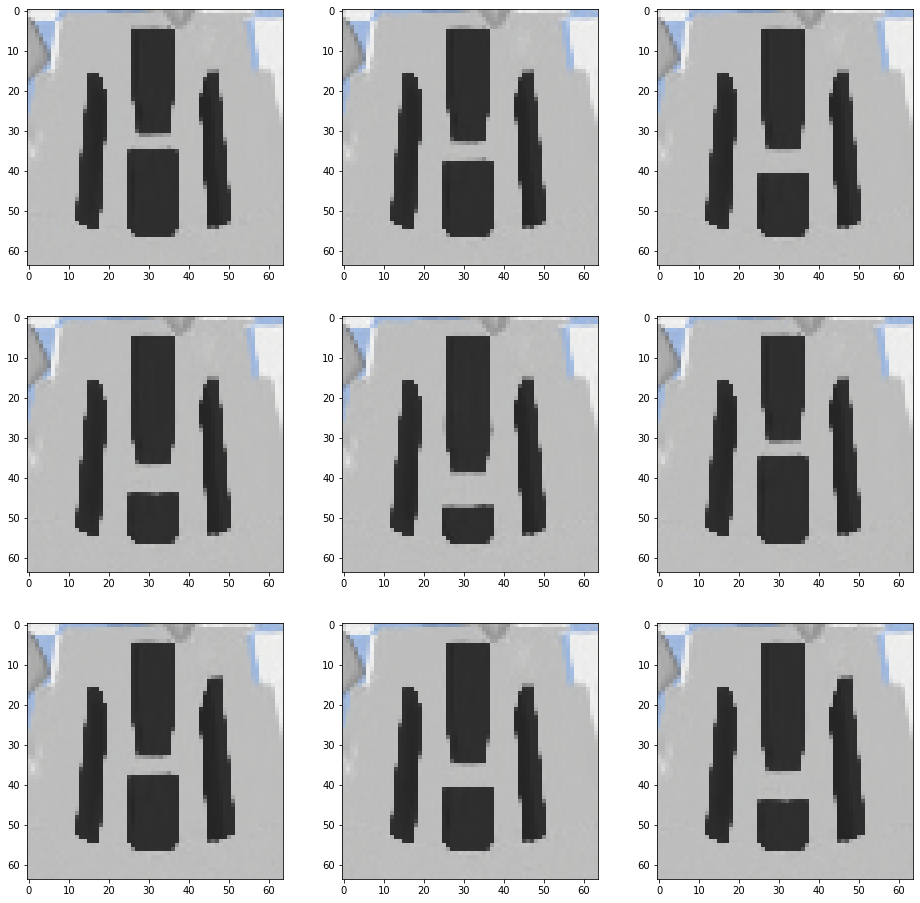

100%|████████| 800/800 [03:07<00:00,  4.28it/s, epoch=199, loss=26, time=0.0432]


In [14]:
for label in tests.keys():
    test_model = test_models[label]
    test_model.to(device=torch.device('cuda:0'))
    test_dataloader = test_dataloaders[label]
    test(test_model, test_dataloader)
    

In [15]:
for label in tests.keys():
    test_model = test_models[label]
    predicted_traj = traj_field(test_model, 100, 1000, number_of_traj = tests[label][1])
    errors = list()
    for i in range(tests[label][1]):
        errors.append(np.linalg.norm(predicted_traj[i]-test_datasets[label].demo_q[i],axis=-1).mean()/np.pi*180) 
    print(label, np.mean(errors))

3x3x3 0.9930507976107336
4x4x4 2.2634346458681334
5x5x5 2.3854625178992244
